# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score



filename_features = "features.txt"
#filename_labels = "activity_labels.txt"
filename_subtrain = "subject_train.txt"
filename_xtrain = "X_train.txt"
filename_ytrain = "y_train.txt"
filename_subtest = "subject_test.txt"
filename_xtest = "X_test.txt"
filename_ytest = "y_test.txt"

# Carregar o arquivo de features sem o argumento 'squeeze'
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
features = pd.Series(features['nome_var'])  # Transformar em Series

#labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Carregar os demais arquivos de forma semelhante, sem 'squeeze'
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

C:\Users\User\AppData\Local\Temp\ipykernel_3864\4287174441.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
C:\Users\User\AppData\Local\Temp\ipykernel_3864\4287174441.py:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [53]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad  = pd.DataFrame(X_test).apply(padroniza, axis=0)

CPU times: total: 500 ms
Wall time: 506 ms


In [9]:
X_train_pad.describe().T

,count,mean,std,min,25%,50%,75%,max
1 tBodyAcc-mean()-X,7352.0,-3.112007e-16,1.0,-18.139254,-0.163858,0.038502,0.198872,10.325905
2 tBodyAcc-mean()-Y,7352.0,4.735663e-17,1.0,-24.069884,-0.175631,0.011671,0.169379,24.937083
3 tBodyAcc-mean()-Z,7352.0,9.181387e-17,1.0,-15.729779,-0.209266,0.008206,0.200360,19.583956
4 tBodyAcc-std()-X,7352.0,-1.469022e-16,1.0,-0.879276,-0.863128,-0.759376,0.808108,3.577703
5 tBodyAcc-std()-Y,7352.0,7.731695e-18,1.0,-0.972726,-0.929466,-0.678330,0.948397,2.839333
...,...,...,...,...,...,...,...,...
"557 angle(tBodyGyroMean,gravityMean)",7352.0,-2.029570e-17,1.0,-1.658262,-0.807162,0.000015,0.817786,1.627440
"558 angle(tBodyGyroJerkMean,gravityMean)",7352.0,3.575909e-17,1.0,-2.079646,-0.774853,0.011743,0.764368,2.096467
"559 angle(X,gravityMean)",7352.0,9.278034e-17,1.0,-0.997354,-0.630155,-0.429596,-0.038163,2.910370
"560 angle(Y,gravityMean)",7352.0,-1.932924e-18,1.0,-3.558535,-0.257085,0.415080,0.637890,1.410395


In [15]:
%%time

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
n_componentes = X_train_pca.shape[1]
nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]
pd.DataFrame(data=X_train_pca, columns=nomes_pca)

CPU times: total: 1.88 s
Wall time: 504 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,-6.449466e-16,-4.157196e-16,-2.820038e-16,1.281587e-16,-1.073747e-15,4.800007e-17,-6.845935e-17,1.558198e-17,-1.265207e-17,6.067627e-18
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-2.710314e-16,2.574864e-16,4.930289e-16,-4.555053e-16,4.030576e-16,-3.228139e-17,-6.782471e-18,1.865808e-17,1.727296e-17,1.893360e-17
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-2.722305e-17,7.612756e-17,-1.007914e-15,9.890529e-16,-7.214503e-16,4.421429e-17,-7.070475e-17,1.616286e-17,-3.030164e-17,-1.200484e-17
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,2.987075e-16,3.472153e-16,-1.466266e-16,-1.477599e-16,7.749197e-17,-3.940634e-17,-2.068351e-17,-4.379502e-17,-3.474029e-17,4.308686e-18
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,4.016337e-16,2.585599e-16,7.807463e-17,5.116911e-16,7.484402e-16,6.741534e-17,-5.141447e-17,1.942757e-17,-2.416294e-17,-1.494192e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285,...,4.948491e-16,-2.623838e-16,3.229169e-16,-2.351773e-16,-5.821889e-17,-2.481032e-17,-3.545474e-17,-2.208255e-17,-7.178372e-18,6.348267e-19
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650,...,1.806260e-16,-3.604692e-17,-5.409110e-17,3.496594e-16,-2.429542e-16,1.606195e-16,1.544266e-16,5.081875e-17,-4.380111e-18,-1.800943e-18
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849,...,3.758476e-17,2.258768e-16,-2.025815e-16,4.024561e-16,-1.530378e-16,-5.960453e-17,-6.118829e-17,7.913383e-18,2.168311e-17,-4.212157e-19
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171,...,2.140261e-17,7.632142e-17,-5.901876e-17,1.908596e-16,3.882399e-16,-4.252646e-18,3.897332e-18,-9.610526e-18,-3.101663e-17,-5.021927e-19


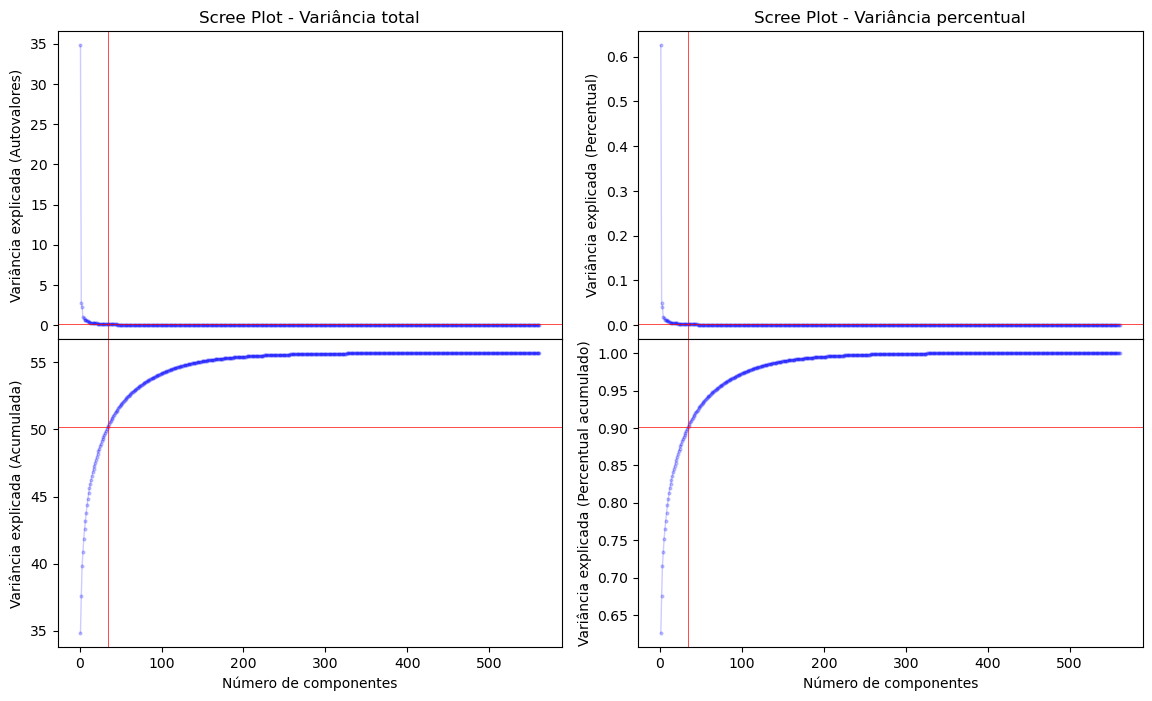

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 34 componentes.


In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

varexplicada = .90  #VAMOS DIZER QUE QUERO EXPLICAR 90% DA VARIABILIDADE DOS DADOS
ncomp_criterio = (pca.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1


# Gráfico da variância nominal por quantidade de componentes
num_componentes = np.arange(pca.n_components_) + 1
ax[0, 0].plot(num_componentes, pca.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes, pca.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes, pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=pca.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=pca.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=pca.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=pca.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()


print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')

In [31]:
variancia               = pca.explained_variance_[ncomp_criterio - 1]
variancia_acumulada     = pca.explained_variance_.cumsum()[ncomp_criterio - 1]
pct_variancia           = pca.explained_variance_ratio_[ncomp_criterio - 1]
pct_variancia_acumulada = pca.explained_variance_ratio_.cumsum()[ncomp_criterio - 1]

print(f'Número de componentes:...................... {ncomp_criterio}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes:...................... 34
Variância da última CP:..................... 0.13
Variância acumulada da última CP:........... 50.15
Variância percentual da última CP:.......... 0.24%
Variância percentual acumulada da última CP: 90.09%


In [33]:
pca_raw = pd.DataFrame(data={'variancia': pca.explained_variance_[:ncomp_criterio], 
                             'variancia_acumulada': pca.explained_variance_.cumsum()[:ncomp_criterio], 
                             'pct_variancia': pca.explained_variance_ratio_[:ncomp_criterio], 
                             'pct_variancia_acumulada': pca.explained_variance_ratio_.cumsum()[:ncomp_criterio]}, 
                       index=list(range(1, ncomp_criterio+1)))
pca_raw.index.name = 'CP'
pca_raw

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,34.823630,34.823630,0.625544,0.625544
2,2.735046,37.558677,0.049130,0.674675
3,2.294393,39.853070,0.041215,0.715889
4,1.043775,40.896845,0.018750,0.734639
5,0.943517,41.840362,0.016949,0.751587
6,0.708152,42.548514,0.012721,0.764308
7,0.655053,43.203567,0.011767,0.776075
8,0.595090,43.798657,0.010690,0.786765
9,0.539647,44.338304,0.009694,0.796459


#### Com Padronização

In [36]:
pca = PCA()
X_train_pad_pca = pca.fit_transform(X_train_pad)
n_componentes = X_train_pad_pca.shape[1]
nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]
pd.DataFrame(data=X_train_pad_pca, columns=nomes_pca)

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,-5.418341e-16,3.314421e-15,2.965124e-15,7.889190e-16,-2.227912e-15,1.636108e-15,1.280400e-15,-2.770666e-16,3.674648e-17,5.666222e-17
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,-2.027888e-15,1.233430e-15,2.598759e-15,-2.475898e-15,-1.786068e-15,6.215657e-16,1.082626e-15,4.043413e-16,2.419654e-16,-1.429421e-17
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,-7.492748e-17,1.922939e-15,8.544294e-17,-1.628057e-16,1.216041e-15,-1.644898e-15,-1.207425e-15,-1.907274e-16,8.218632e-17,1.056602e-16
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,-2.593506e-15,1.799579e-15,1.919694e-16,-4.613521e-16,3.071864e-15,-2.715050e-15,-3.430846e-15,1.193541e-15,-6.090980e-16,-5.636781e-17
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-1.389241e-16,4.154775e-16,-1.477372e-15,1.786024e-15,2.206954e-15,-1.485376e-16,8.792641e-16,6.823254e-16,-3.911553e-16,-8.819410e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,15.464009,-12.535453,1.999041,3.457489,-1.523091,-2.698944,-3.561009,2.418529,0.383154,1.308633,...,1.983463e-15,3.910966e-16,-9.371571e-17,1.147862e-15,2.212882e-16,-2.528934e-15,8.809517e-16,3.347058e-16,2.059270e-16,2.426767e-18
7348,14.221755,-10.252804,2.377499,2.802476,-1.325223,-4.345821,-2.193817,0.032138,-0.528893,0.702462,...,-1.044190e-15,-5.327838e-16,-3.401542e-16,-2.087979e-15,-3.947545e-16,-4.644825e-16,5.208270e-16,-1.204289e-15,-2.262588e-16,-5.725991e-17
7349,14.332461,-12.259878,4.025672,3.849518,-2.860295,-3.623803,-3.929374,-0.873103,-0.746280,-1.575419,...,1.334920e-16,3.759300e-16,4.268087e-16,-2.099728e-16,-3.080554e-16,4.665060e-16,6.664681e-16,1.186277e-16,2.832088e-16,-6.332799e-17
7350,12.875143,-14.070299,2.915863,5.013085,-3.937957,-2.137461,-5.390033,0.321283,-0.916237,-1.646259,...,-2.542263e-16,-3.129683e-16,-2.145329e-16,5.925800e-17,-2.647451e-16,7.922408e-16,2.288586e-16,3.476364e-16,-1.638016e-17,-7.544039e-18


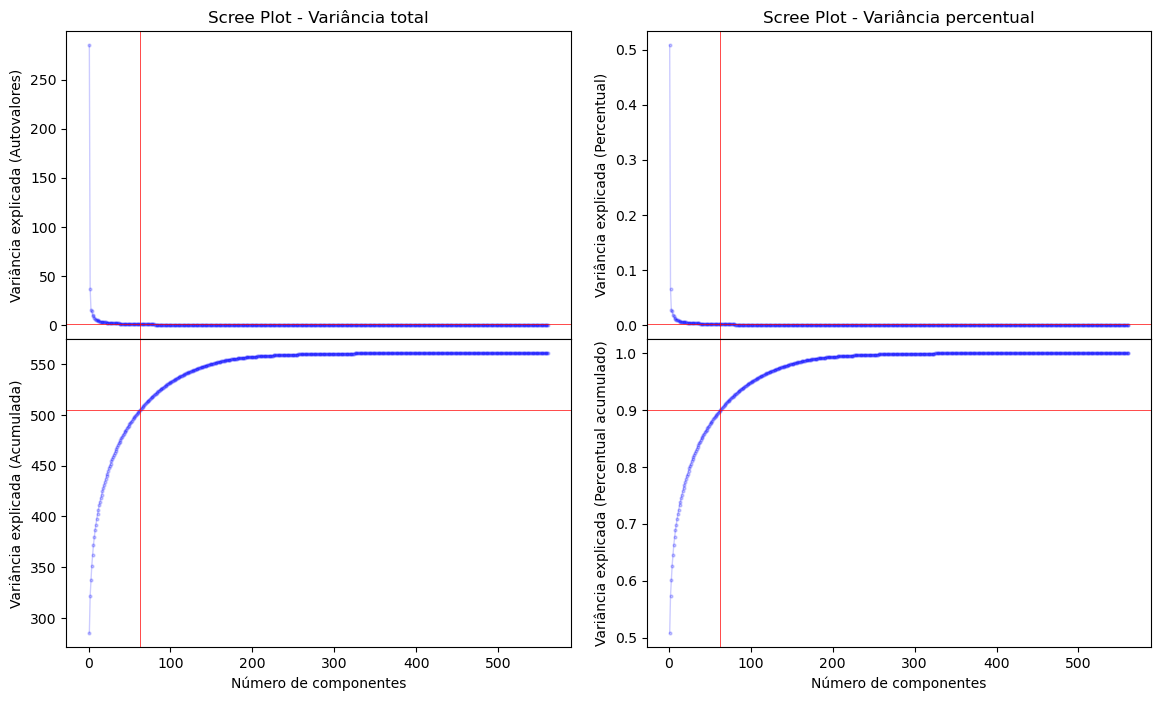

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 63 componentes.
Para o critério de autovalor > 1, são necessárias 61 componentes.


In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

varexplicada = .90  #VAMOS DIZER QUE QUERO EXPLICAR 90% DA VARIABILIDADE DOS DADOS
ncomp_criterio = (pca.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1


# Gráfico da variância nominal por quantidade de componentes
num_componentes = np.arange(pca.n_components_) + 1
ax[0, 0].plot(num_componentes, pca.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes, pca.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes, pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=pca.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=pca.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=pca.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=pca.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()



print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')
criterio_autovalor = (pca.explained_variance_ratio_ > 1 / pca.n_components_).sum()
print(f'Para o critério de autovalor > 1, são necessárias {criterio_autovalor} componentes.')

In [42]:
variancia               = pca.explained_variance_[ncomp_criterio - 1]
variancia_acumulada     = pca.explained_variance_.cumsum()[ncomp_criterio - 1]
pct_variancia           = pca.explained_variance_ratio_[ncomp_criterio - 1]
pct_variancia_acumulada = pca.explained_variance_ratio_.cumsum()[ncomp_criterio - 1]

print(f'Número de componentes:...................... {ncomp_criterio}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes:...................... 63
Variância da última CP:..................... 0.99
Variância acumulada da última CP:........... 505.20
Variância percentual da última CP:.......... 0.18%
Variância percentual acumulada da última CP: 90.05%


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [59]:
%%time

pca = PCA(n_components=10)

pc_treino = pca.fit_transform(X_train)
pc_teste  = pca.transform(X_test)

print(f'Dimensões da base de treinamento: {pc_treino.shape}')
print(f'Dimensões da base de teste: {pc_teste.shape}\n')

clf = DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(pc_treino, y_train)

print(f'Acurácia na base de treinamento: {clf.score(pc_treino, y_train)}')
print(f'Acurácia na base de teste: {clf.score(pc_teste, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8915941240478781
Acurácia na base de teste: 0.8215134034611469

CPU times: total: 1.17 s
Wall time: 330 ms


#### Com Padronização

In [63]:
pca = PCA(n_components=10)

pc_treino_pad = pca.fit_transform(X_train_pad)
pc_teste_pad  = pca.transform(X_test_pad)

print(f'Dimensões da base de treinamento: {pc_treino_pad.shape}')
print(f'Dimensões da base de teste: {pc_teste_pad.shape}\n')

clf_pad = DecisionTreeClassifier(ccp_alpha=0.001)
clf_pad.fit(pc_treino_pad, y_train)

print(f'Acurácia na base de treinamento: {clf_pad.score(pc_treino_pad, y_train)}')
print(f'Acurácia na base de teste: {clf_pad.score(pc_teste_pad, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.85949401523395
Acurácia na base de teste: 0.7757041058703766



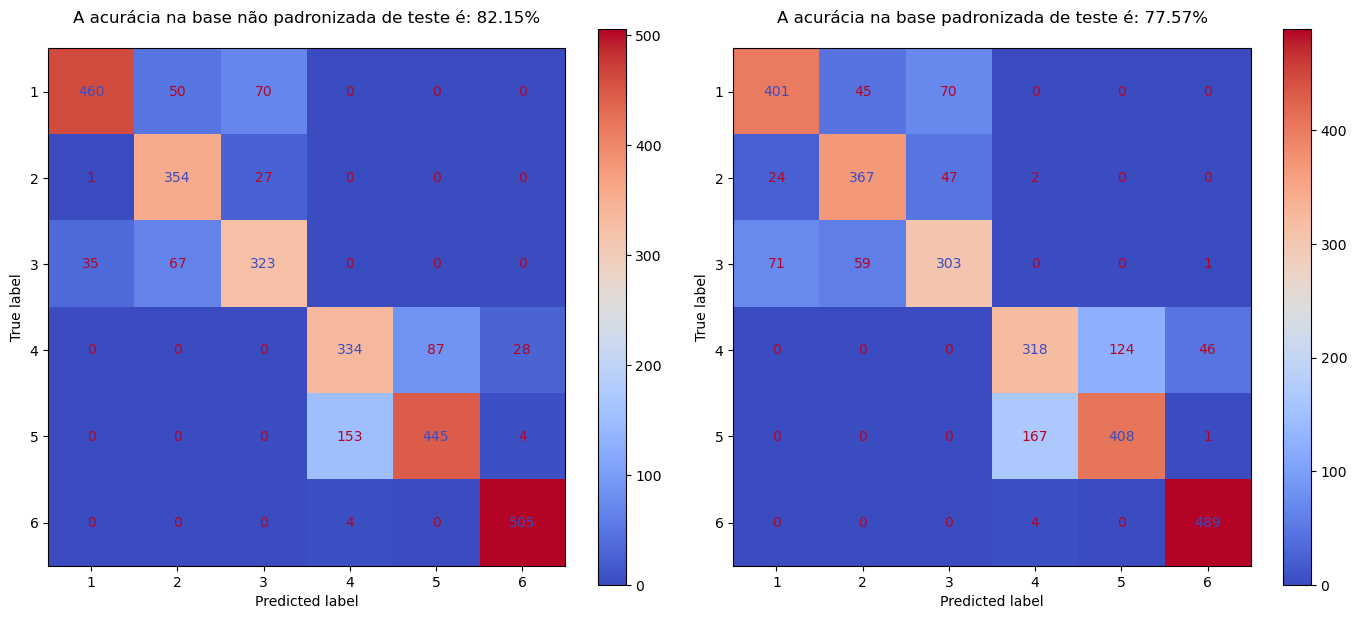

In [73]:
from sklearn.metrics       import ConfusionMatrixDisplay

y_pred = clf.predict(pc_teste)
y_pred_pad = clf_pad.predict(pc_teste_pad)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax[0].set_title(f'A acurácia na base não padronizada de teste é: {accuracy_score(y_pred, y_test) * 100:.2f}%\n')
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[0],cmap='coolwarm')
ax[1].set_title(f'A acurácia na base padronizada de teste é: {accuracy_score(y_pred_pad, y_test) * 100:.2f}%\n')

ConfusionMatrixDisplay.from_predictions(y_pred_pad, y_test, ax=ax[1],cmap='coolwarm')
plt.tight_layout()
plt.show()